In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

In [2]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [4]:
from functions import log, plot_top_words

In [5]:
df = pd.read_csv('files/select_files.txt', delimiter= '\t')

In [6]:
df = df[["PMID", "title", "abstract"]]

In [7]:
groupBy = "abstract" # title or abstract

In [8]:
df = df.dropna()

stop_words = set(stopwords.words('english'))

def parseGroupString(abstract):
    temp = re.sub('doi', '', abstract, flags=re.IGNORECASE) 
    temp = re.sub(' .*10\.1371.* ', ' ', temp)
    temp = re.sub(r'[^\w\s]', '', temp)
    temp = temp.lower()
    temp = word_tokenize(temp)
    temp = [w for w in temp if not w in stop_words]
    temp = ' '.join([lemmatizer.lemmatize(w) for w in temp])
    return temp
                     
df[groupBy] = [ parseGroupString(x) for x in df[groupBy] ]

In [9]:
len(df)

3996

In [10]:
# tempdf = df[df["references"].str.len()>3]
# tempdf

In [11]:
#count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
#doc_term_matrix = count_vect.fit_transform(df['abstract'].values.astype('U')) # U converts to unicode

In [12]:
df

,PMID,title,abstract
0,12929205,The Transcriptome of the Intraerythrocytic Dev...,plasmodium falciparum causative agent burdenso...
1,12929206,DNA Analysis Indicates That Asian Elephants Ar...,origin borneo elephant controversial two compe...
2,12975658,Drosophila Free-Running Rhythms Require Interc...,robust selfsustained oscillation ubiquitous ch...
3,12975657,From Gene Trees to Organismal Phylogeny in Pro...,rapid increase published genomic sequence bact...
4,14551903,A Functional Analysis of the Spacer of V(D)J R...,lymphocyte development vdj recombination assem...
...,...,...,...
3994,17925860,Large-Scale Mitochondrial DNA Analysis of the ...,backgroundfrom beginning domestication transpo...
3995,17925881,"Endothelial Progenitor Cells, Cardiovascular R...",backgroundepc number functionality assumed ref...
3996,17925862,Ataxin-1 Fusion Partners Alter PolyQ Lethality...,intranuclear inclusion body ibs histopathologi...
3997,17925864,The Chemokine Receptor CXCR4 Strongly Promotes...,neuroblastoma nb heterogeneous particularly ma...


In [13]:
tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words="english")
tfidf = tfidf_vect.fit_transform(df[groupBy].values.astype('U'))

In [14]:
df = df[["PMID", "title"]]

In [15]:
n_top_words = 10 # for bar graph
n_topics = 5

In [16]:
nmf1 = NMF(
    n_components=n_topics,
    beta_loss="frobenius", #"frobenius"
    solver="cd",
    max_iter=1000,
    l1_ratio=0.5,
).fit(tfidf)

log(f'fitting {n_topics}')

c:\users\danny\miniconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


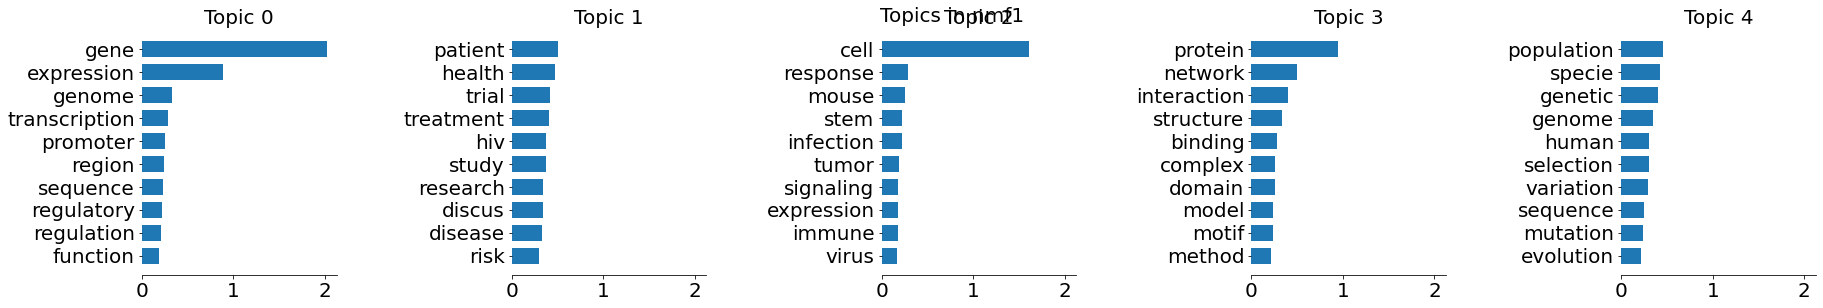

In [17]:
plot_top_words(
    nmf1, tfidf_vect.get_feature_names_out(), n_topics, n_top_words,"Topics in nmf1"
)

In [18]:
X_new = nmf1.transform(tfidf)
# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

In [19]:
df["topic"] = predicted_topics

<AxesSubplot:ylabel='Frequency'>

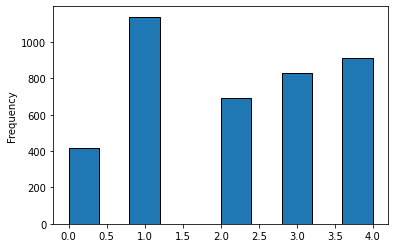

In [20]:
df['topic'].plot(kind='hist', edgecolor='black')

In [21]:
df = df[["PMID","topic"]]

In [22]:
topicDict = {}

for i,topic in enumerate(nmf1.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1] # finds indeces of n top words
    top_features = [tfidf_vect.get_feature_names_out()[i] for i in top_features_ind] # gets the actual words
    topicDict[i] = top_features
    
print(topicDict)

{0: ['gene', 'expression', 'genome', 'transcription', 'promoter', 'region', 'sequence', 'regulatory', 'regulation', 'function'], 1: ['patient', 'health', 'trial', 'treatment', 'hiv', 'study', 'research', 'discus', 'disease', 'risk'], 2: ['cell', 'response', 'mouse', 'stem', 'infection', 'tumor', 'signaling', 'expression', 'immune', 'virus'], 3: ['protein', 'network', 'interaction', 'structure', 'binding', 'complex', 'domain', 'model', 'motif', 'method'], 4: ['population', 'specie', 'genetic', 'genome', 'human', 'selection', 'variation', 'sequence', 'mutation', 'evolution']}


In [23]:
with open(r'files/topicDict.pkl', 'wb') as f:
    pickle.dump(topicDict, f)
    
log(f'saving main word of topic to files/topicDict.pkl')

In [24]:
df.to_csv(r'files/topics_abstract.txt', sep='\t', index = False)
log(f'Ran topics_abstract.ipynb succesfully')

In [25]:
df

,PMID,topic
0,12929205,0
1,12929206,4
2,12975658,3
3,12975657,4
4,14551903,3
...,...,...
3994,17925860,4
3995,17925881,1
3996,17925862,3
3997,17925864,2
